In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from GA import GeneticAlgorithm
import matplotlib.patches as patches
import time
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")


In [2]:
r800 = pd.read_csv('data/r800.csv', header=None)
r850 = pd.read_csv('data/r850.csv', header=None)
r1000 = pd.read_csv('data/r1000.csv', header=None)
r1100 = pd.read_csv('data/r1100.csv', header=None)
r1200 = pd.read_csv('data/r1200.csv', header=None)

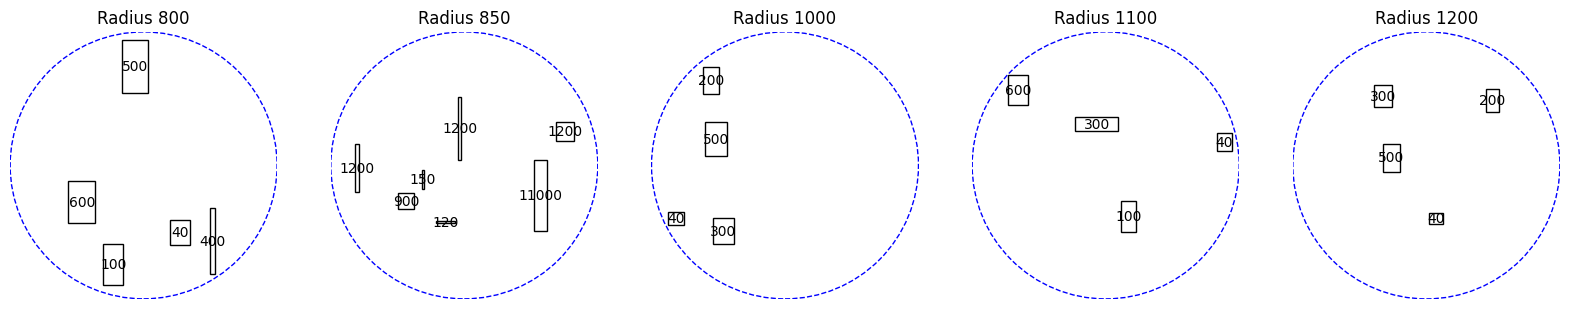

In [3]:
def plot_circle_and_rectangles(ax, data, r):
    # Plotting the circle
    circle = plt.Circle((0, 0), r, fill=False, color='blue', linestyle='--')
    ax.add_artist(circle)
    
    # Plotting the rectangles
    for row in data:
        height, width, value = row
        # For this example, let's place the rectangles sequentially starting from the left
        # You can adjust the positioning logic as needed
        x = np.random.uniform(-r, r - width)
        y = np.random.uniform(-r, r - height)
        
        # Ensure the rectangle lies within the circle
        while (x**2 + y**2 > r**2) or ((x + width)**2 + y**2 > r**2) or (x**2 + (y + height)**2 > r**2) or ((x + width)**2 + (y + height)**2 > r**2):
            x = np.random.uniform(-r, r - width)
            y = np.random.uniform(-r, r - height)
        
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        
        # Adding the value inside the rectangle
        ax.text(x + width / 2, y + height / 2, str(value), horizontalalignment='center', verticalalignment='center')

    ax.set_xlim(-r - 1, r + 1)
    ax.set_ylim(-r - 1, r + 1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Radius {r}')
    ax.grid(False)
    ax.axis('off')

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
i=0
for data, r in zip([r800, r850, r1000, r1100, r1200], [800, 850, 1000, 1100, 1200]):
    plot_circle_and_rectangles(axs[i], data.values, r)
    i+=1


In [5]:
def plot_solution(data, r):
    fig, ax = plt.subplots()
    
    # Plotting the circle
    circle = plt.Circle((0, 0), r, fill=False, color='blue', linestyle='--')
    ax.add_artist(circle)
    total_value = 0
    # Plotting the rectangles
    for row in data:
        # height, width, value = row
        # # For this example, let's place the rectangles sequentially starting from the left
        # # You can adjust the positioning logic as needed
        # x = np.random.uniform(-r, r - width)
        # y = np.random.uniform(-r, r - height)
        
        # # Ensure the rectangle lies within the circle
        # while (x**2 + y**2 > r**2) or ((x + width)**2 + y**2 > r**2) or (x**2 + (y + height)**2 > r**2) or ((x + width)**2 + (y + height)**2 > r**2):
        #     x = np.random.uniform(-r, r - width)
        #     y = np.random.uniform(-r, r - height)
        x, y, height, width, value = row
        total_value += value
        
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        
        # Adding the value inside the rectangle

        plt.text(x + width / 2, y + height / 2, str(value), horizontalalignment='center', verticalalignment='center')

    ax.set_xlim(-r - 1, r + 1)
    ax.set_ylim(-r - 1, r + 1)
    ax.set_aspect('equal', adjustable='box')
    plt.title(f'Circle with Radius {r} and Rectangles, Total Value: {total_value}')
    plt.show()

def plot_solution2(data, r):
    fig, ax = plt.subplots()
    
    # Plotting the circle
    circle = plt.Circle((0, 0), r, fill=False, color='blue', linestyle='--')
    ax.add_artist(circle)
    total_value = 0
    
    # Get the minimum and maximum values for normalization
    values = [row[4] for row in data]
    min_value, max_value = min(values), max(values)
    
    # Normalize values for colormap
    norm = plt.Normalize(min_value, max_value)
    cmap = cm.get_cmap('viridis')
    
    # Plotting the rectangles
    for row in data:
        x, y, height, width, value = row
        total_value += value
        
        # Normalize the value to get a color
        color = cmap(norm(value))
        
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
    
    ax.set_xlim(-r - 1, r + 1)
    ax.set_ylim(-r - 1, r + 1)
    ax.set_aspect('equal', adjustable='box')
    plt.title(f'Circle with Radius {r} and Rectangles, Total Value: {total_value}')
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for the colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Value')
    
    plt.show()

In [21]:
class GAlgorithm:
    def __init__(
            self, 
            population_size, 
            initial_chromosome_length, 
            radius,
            rectangles,
            rect_prob = False,
            crossover_prob=0.7, 
            mutation_prob = 0.2, 
            num_generations=100,
            verbose=True,
            # initial_sigma=10,
            # sigma_decay=0.05,
            rotate = False,
            init_max_iter = 2000
    ):
        self.population_size = population_size
        self.initial_chromosome_length = initial_chromosome_length
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        # self.function_to_optimize = None
        self.num_generations = num_generations
        # self.initial_sigma = initial_sigma
        # self.sigma = initial_sigma
        self.radius = radius
        self.rectangles = rectangles.values
        if rotate: 
            self.rectangles = np.append(self.rectangles, [[w, h, v] for h, w, v in self.rectangles], axis=0)
        self.verbose = verbose
        # self.sigma_decay = sigma_decay
        self.best_chromosome = None
        self.best_fitness = None
        # self.rectangle_probabilities = []
        # s = sum([(v/(h * w)) for h, w, v in self.rectangles])
        # for h, w, v in self.rectangles:
        #     self.rectangle_probabilities.append( (v/(h * w)) / s)
        self.rectangle_probabilities = [(v/(h * w)) for h, w, v in self.rectangles]
        self.rectangle_probabilities[np.argmax(self.rectangle_probabilities)] *= 1000
        self.rectangle_probabilities = self.rectangle_probabilities / np.sum(self.rectangle_probabilities)
        self.rectangle_probabilities = self.rectangle_probabilities if rect_prob else [1/len(self.rectangles) for _ in range(len(self.rectangles))]
        self.init_max_iter = init_max_iter
        s = 5*self.radius
        self.directions = [(s, 0), (0, s), (-s, 0), (0, -s)]
       


    def _random_xy(self, h, w):
        x = np.random.uniform(-self.radius, self.radius - w)
        y = np.random.uniform(-self.radius, self.radius - h)
        while (x**2 + y**2 > self.radius**2) or ((x + w)**2 + y**2 > self.radius**2) or (x**2 + (y + h)**2 > self.radius**2) or ((x + w)**2 + (y + h)**2 > self.radius**2):
            x = np.random.uniform(-self.radius, self.radius - w)
            y = np.random.uniform(-self.radius, self.radius - h)
        return x, y
    
    def _new_chromosome(self):
        chromosome = []
        i = 0
        while len(chromosome) < self.initial_chromosome_length and i < self.init_max_iter:
            i+=1
            gene = self._new_gene()
            x, y, h, w, _ = gene
            if not self._does_overlap(x, y, h, w, chromosome):
                chromosome.append(gene)
        return chromosome
            
    
    def _new_gene(self):
        i = np.random.choice(range(len(self.rectangles)), p=self.rectangle_probabilities)
        h, w, v = self.rectangles[i]
        x, y = self._random_xy(h, w)
        return (x, y, h, w, v)

    def _initialize_population(self):
        # s = 5*self.radius
        # direction = [(s, 0), (0, s), (-s, 0), (0, -s), (np.sqrt(s**2/2), np.sqrt(s**2/2)), (-np.sqrt(s**2/2), np.sqrt(s**2/2)), (-np.sqrt(s**2/2), -np.sqrt(s**2/2)), (np.sqrt(s**2/2), -np.sqrt(s**2/2))]
        self.population = [self._new_chromosome() for _ in range(self.population_size)]
        # self.directions = [direction[i % len(direction)] for i in range(self.population_size)]
    
    def _any_overlap_in_chromosome(self, chromosome):
        for i in range(len(chromosome)):
            x1, y1, h1, w1, _ = chromosome[i]
            for j in range(i + 1, len(chromosome)):
                x2, y2, h2, w2, _ = chromosome[j]
                if (x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2):
                    return True
        return False
    
    def _does_overlap(self, x, y, h, w, chromosome):
        for x1, y1, h1, w1, _ in chromosome:
            if (x < x1 + w1 and x + w > x1 and y < y1 + h1 and y + h > y1):
                return True
        return False
    
    def _is_inside_circle(self, x, y, h, w):    
        return (x**2 + y**2 <= self.radius**2) and ((x + w)**2 + y**2 <= self.radius**2) and (x**2 + (y + h)**2 <= self.radius**2) and ((x + w)**2 + (y + h)**2 <= self.radius**2)
    
    def _fitness(self, chromosome):
        # if self._any_overlap_in_chromosome(chromosome):
        #     return 0
        fitness = sum(v for _, _, _, _, v in chromosome)

        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_chromosome = chromosome.copy()
        return fitness
    
    def _evaluate_population(self):
        self.fitnesses = [self._fitness(chromosome) for chromosome in self.population]
    
    def _shift(self, chromosome):
        direction = self.directions[np.random.randint(0, len(self.directions))]
        chromosome.sort(key=lambda x: (x[0] - direction[0])**2 + (x[1] - direction[1])**2)
        for i in range(len(chromosome)):
            x, y, h, w, v = chromosome[i]
            # x_diff, y_diff = direction[0] - x, direction[1] - y 
            x_diff, y_diff = direction
            step = 0.001  
            chromosome_without_i = chromosome[:i] + chromosome[i+1:]
            while not self._does_overlap(x + x_diff * step, y + y_diff* step, h, w, chromosome_without_i) and self._is_inside_circle(x + x_diff* step, y + y_diff* step, h, w):
                x += x_diff * step
                y += y_diff * step
            chromosome[i] = (x, y, h, w, v)
        return chromosome
    
    def _insert(self, chromosome):
        for _ in range(10):
            x, y, h, w, v = self._new_gene()
            if not self._does_overlap(x, y, h, w, chromosome):
                chromosome.append((x, y, h, w, v))
                return chromosome
        return chromosome 
    
    def _mutate(self, chromosome):
        if np.random.rand() < self.mutation_prob:
            if np.random.rand() < 0.5:
                return self._shift(chromosome)
            return self._insert(chromosome)
        return chromosome
    
    def _crossover(self, parent1, parent2):
        if np.random.rand() > self.crossover_prob:
            return parent1, parent2
        for gene in parent1:
            if not self._does_overlap(*gene[:4], parent2):
                parent2.append(gene)
        for gene in parent2:
            if not self._does_overlap(*gene[:4], parent1):
                parent1.append(gene)
        return parent1, parent2
    
    def _roulette_wheel_selection(self):
        fitness_sum = sum(self.fitnesses)
        probabilities = [f/fitness_sum for f in self.fitnesses] if fitness_sum > 0 else [1/self.population_size for _ in range(self.population_size)]
        return self.population[np.random.choice(range(self.population_size), p=probabilities)], self.population[np.random.choice(range(self.population_size), p=probabilities)]
    
    def _evolve(self):
        new_population = []
        for _ in range(self.population_size // 2):
            parent1, parent2 = self._roulette_wheel_selection()
            child1, child2 = self._crossover(parent1, parent2)
            new_population.append(self._mutate(child1))
            new_population.append(self._mutate(child2))
        self.population = new_population

    def optimize(self):
        self._initialize_population()
        self.best_fitness = 0
        for i in range(1, 1+self.num_generations):
            self._evaluate_population()
            self._evolve()
            # self.sigma = self.initial_sigma * np.exp(-self.sigma_decay * i)
            # if i % np.ceil(self.num_generations/2) == 0:

            if i % np.ceil(self.num_generations/2) == 0:
                self.rectangle_probabilities[np.argmax(self.rectangle_probabilities)] /= 1100 

                self.rectangle_probabilities = self.rectangle_probabilities / np.sum(self.rectangle_probabilities)
                # self.rectangle_probabilities = [1/len(self.rectangles) for _ in range(len(self.rectangles))]
            if self.verbose and i % np.ceil(self.num_generations/100) == 0:
                print(f'Generation {i}, best fitness: {self.best_fitness}')
        return self.best_chromosome, self.best_fitness



        


## Dobre wyniki

Generation 1, best fitness: 9400
Generation 2, best fitness: 12880
Generation 3, best fitness: 18680
Generation 4, best fitness: 23120
Generation 5, best fitness: 26420
Generation 6, best fitness: 29300
Generation 7, best fitness: 32300
Generation 8, best fitness: 33140
Generation 9, best fitness: 33540
Generation 10, best fitness: 34780
Radius 800, Best Fitness: 34780, Time: 10.65731406211853, Min Fitness: 30000


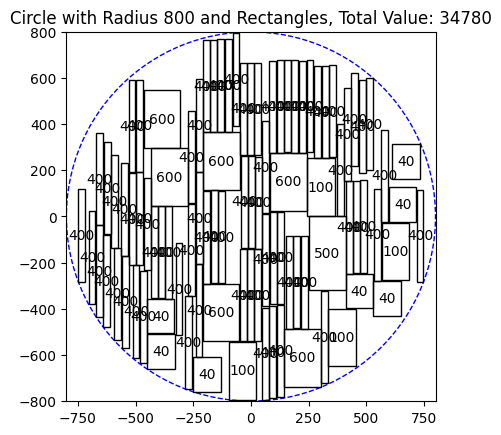

Generation 1, best fitness: 111120
Generation 2, best fitness: 193440
Generation 3, best fitness: 207780
Generation 4, best fitness: 222300
Generation 5, best fitness: 248030
Generation 6, best fitness: 263610
Generation 7, best fitness: 274650
Generation 8, best fitness: 286860
Generation 9, best fitness: 290910
Generation 10, best fitness: 293310
Radius 850, Best Fitness: 293310, Time: 137.6242697238922, Min Fitness: 0


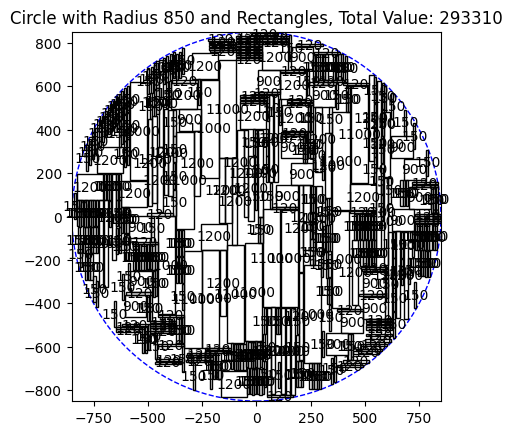

Generation 1, best fitness: 7160
Generation 2, best fitness: 12180
Generation 3, best fitness: 13460
Generation 4, best fitness: 17820
Generation 5, best fitness: 18020
Generation 6, best fitness: 20620
Generation 7, best fitness: 21500
Generation 8, best fitness: 21580
Generation 9, best fitness: 21660
Generation 10, best fitness: 22020
Radius 1000, Best Fitness: 22020, Time: 12.21846342086792, Min Fitness: 17500


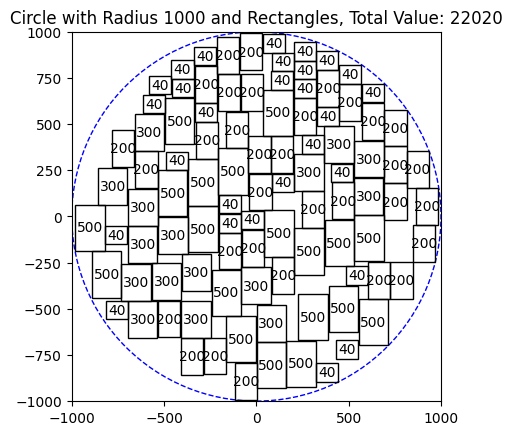

Generation 1, best fitness: 10600
Generation 2, best fitness: 13780
Generation 3, best fitness: 20040
Generation 4, best fitness: 24180
Generation 5, best fitness: 25960
Generation 6, best fitness: 29120
Generation 7, best fitness: 29800
Generation 8, best fitness: 30140
Generation 9, best fitness: 30180
Generation 10, best fitness: 30320
Radius 1100, Best Fitness: 30320, Time: 12.865936756134033, Min Fitness: 25000


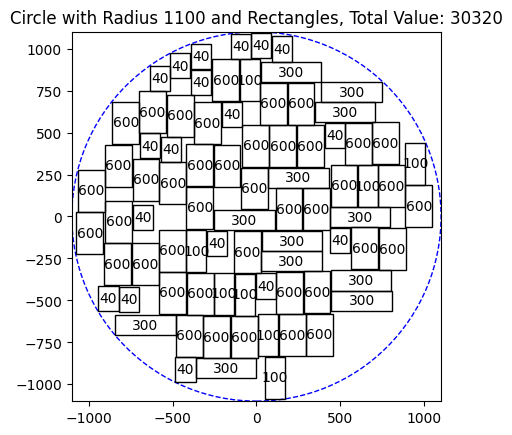

Generation 1, best fitness: 7440
Generation 2, best fitness: 15760
Generation 3, best fitness: 21300
Generation 4, best fitness: 26760
Generation 5, best fitness: 28180
Generation 6, best fitness: 29800
Generation 7, best fitness: 30080
Generation 8, best fitness: 30840
Generation 9, best fitness: 32020
Generation 10, best fitness: 32440
Radius 1200, Best Fitness: 32440, Time: 27.347291231155396, Min Fitness: 30000


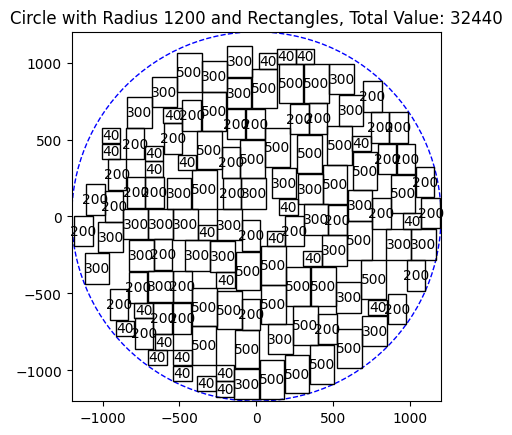

In [240]:
for r, data, min_fitness in zip([800, 850, 1000, 1100, 1200], [r800, r850, r1000, r1100, r1200], [30000, 0, 17500, 25000, 30000]):
    ga = GAlgorithm(
        population_size=50,
        initial_chromosome_length=20,
        radius=r,
        rectangles=data,
        crossover_prob=0.7,
        mutation_prob=0.2,
        num_generations=10,
        verbose=1,
        rect_prob = 1,
        rotate = False,
        init_max_iter = 2000
    )
    start = time.time()
    best_chromosome, best_fitness = ga.optimize()
    print(f'Radius {r}, Best Fitness: {best_fitness}, Time: {time.time() - start}, Min Fitness: {min_fitness}')
    plot_solution(best_chromosome, r)

Generation 1, best fitness: 9500
Generation 2, best fitness: 13340
Generation 3, best fitness: 15720
Generation 4, best fitness: 17320
Generation 5, best fitness: 18520
Generation 6, best fitness: 23020
Generation 7, best fitness: 23820
Generation 8, best fitness: 24960
Generation 9, best fitness: 27000
Generation 10, best fitness: 27000
Radius 800, Best Fitness: 27000, Time: 7.660118341445923, Min Fitness: 30000


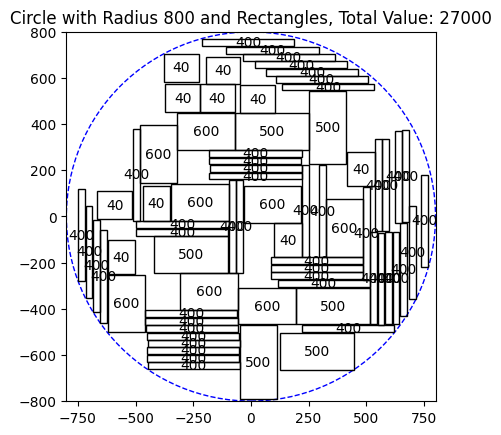

Generation 1, best fitness: 7940
Generation 2, best fitness: 10680
Generation 3, best fitness: 14380
Generation 4, best fitness: 17900
Generation 5, best fitness: 20540
Generation 6, best fitness: 21120
Generation 7, best fitness: 22780
Generation 8, best fitness: 22820
Generation 9, best fitness: 22900
Generation 10, best fitness: 22940
Radius 1000, Best Fitness: 22940, Time: 14.505698204040527, Min Fitness: 17500


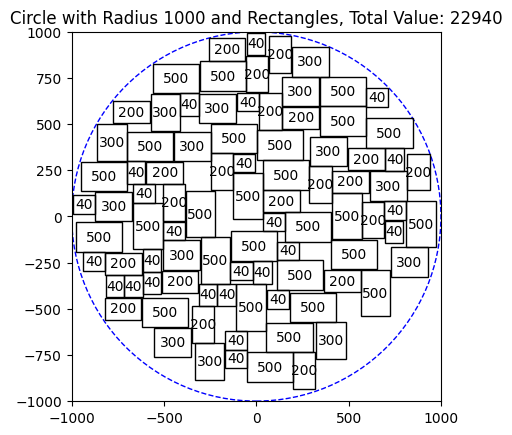

Generation 1, best fitness: 10200
Generation 2, best fitness: 13440
Generation 3, best fitness: 17740
Generation 4, best fitness: 23960
Generation 5, best fitness: 25800
Generation 6, best fitness: 25800
Generation 7, best fitness: 26400
Generation 8, best fitness: 27000
Generation 9, best fitness: 28180
Generation 10, best fitness: 28220
Radius 1100, Best Fitness: 28220, Time: 14.337446451187134, Min Fitness: 25000


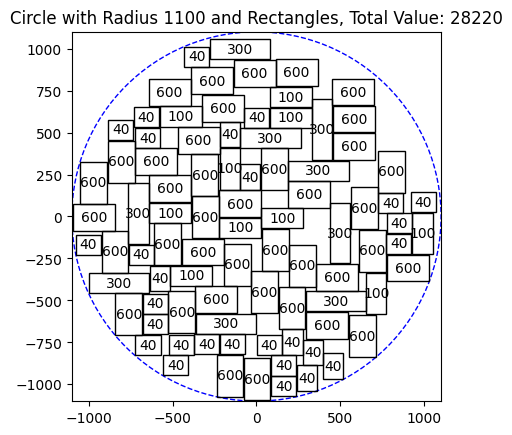

Generation 1, best fitness: 7640
Generation 2, best fitness: 15440
Generation 3, best fitness: 18340
Generation 4, best fitness: 19940
Generation 5, best fitness: 23100
Generation 6, best fitness: 26340
Generation 7, best fitness: 28460
Generation 8, best fitness: 29700
Generation 9, best fitness: 29900
Generation 10, best fitness: 31560
Radius 1200, Best Fitness: 31560, Time: 27.14676308631897, Min Fitness: 30000


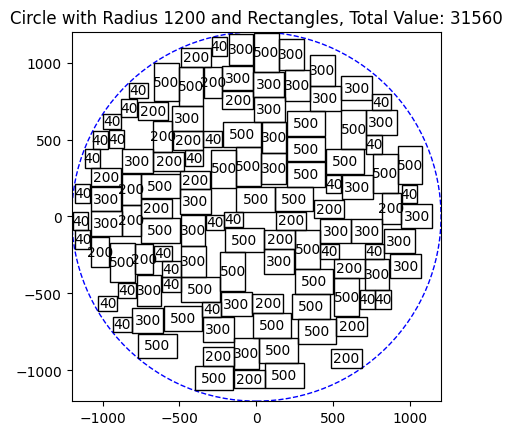

In [241]:
for r, data, min_fitness in zip([800, 1000, 1100, 1200], [r800, r1000, r1100, r1200], [30000, 17500, 25000, 30000]):
    ga = GAlgorithm(
        population_size=50,
        initial_chromosome_length=20,
        radius=r,
        rectangles=data,
        crossover_prob=0.7,
        mutation_prob=0.2,
        num_generations=10,
        verbose=1,
        rect_prob = 1,
        rotate = 1,
        init_max_iter = 2000
    )
    start = time.time()
    best_chromosome, best_fitness = ga.optimize()
    print(f'Radius {r}, Best Fitness: {best_fitness}, Time: {time.time() - start}, Min Fitness: {min_fitness}')
    plot_solution(best_chromosome, r)

Generation 1, best fitness: 8700
Generation 2, best fitness: 10660
Generation 3, best fitness: 10700
Generation 4, best fitness: 12300
Generation 5, best fitness: 15640
Generation 6, best fitness: 16440
Generation 7, best fitness: 16920
Generation 8, best fitness: 17320
Generation 9, best fitness: 17360
Generation 10, best fitness: 18820
Radius 800, Best Fitness: 18820, Time: 6.500743627548218, Min Fitness: 30000


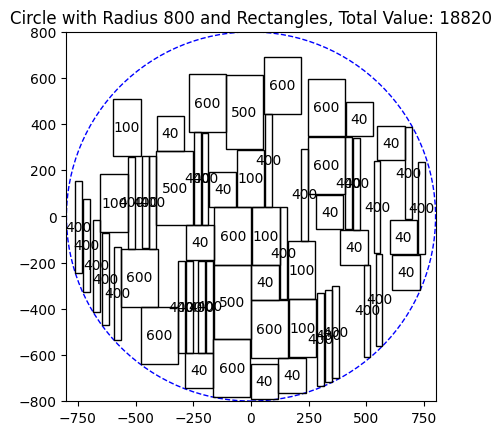

Generation 1, best fitness: 6180
Generation 2, best fitness: 8900
Generation 3, best fitness: 11040
Generation 4, best fitness: 13100
Generation 5, best fitness: 15080
Generation 6, best fitness: 15740
Generation 7, best fitness: 16720
Generation 8, best fitness: 17400
Generation 9, best fitness: 17400
Generation 10, best fitness: 17400
Radius 1000, Best Fitness: 17400, Time: 22.381473779678345, Min Fitness: 17500


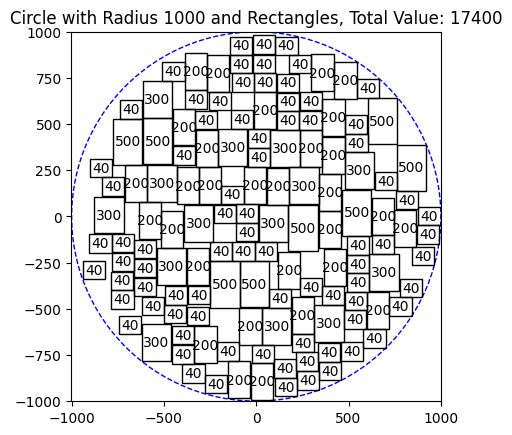

Generation 1, best fitness: 7880
Generation 2, best fitness: 12900
Generation 3, best fitness: 16540
Generation 4, best fitness: 16880
Generation 5, best fitness: 18680
Generation 6, best fitness: 19540
Generation 7, best fitness: 20320
Generation 8, best fitness: 20980
Generation 9, best fitness: 21020
Generation 10, best fitness: 21780
Radius 1100, Best Fitness: 21780, Time: 15.447986364364624, Min Fitness: 25000


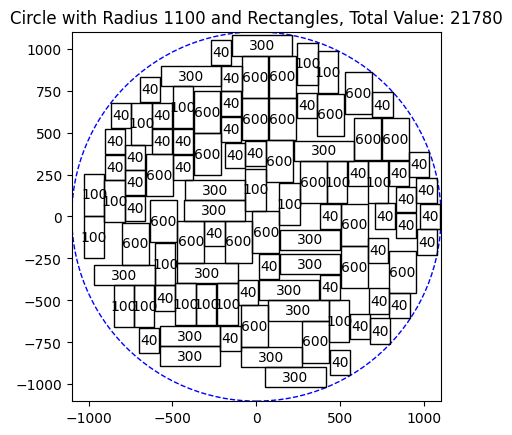

Generation 1, best fitness: 6620
Generation 2, best fitness: 12660
Generation 3, best fitness: 18760
Generation 4, best fitness: 20940
Generation 5, best fitness: 24140
Generation 6, best fitness: 24500
Generation 7, best fitness: 26720
Generation 8, best fitness: 27880
Generation 9, best fitness: 27920
Generation 10, best fitness: 28000
Radius 1200, Best Fitness: 28000, Time: 35.397627115249634, Min Fitness: 30000


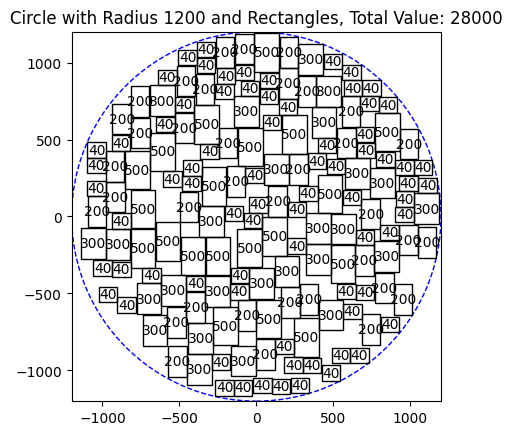

In [242]:
for r, data, min_fitness in zip([800, 1000, 1100, 1200], [r800, r1000, r1100, r1200], [30000, 17500, 25000, 30000]):
    ga = GAlgorithm(
        population_size=50,
        initial_chromosome_length=20,
        radius=r,
        rectangles=data,
        crossover_prob=0.7,
        mutation_prob=0.2,
        num_generations=10,
        verbose=1,
        rect_prob = 0,
        rotate = 0,
        init_max_iter = 2000
    )
    start = time.time()
    best_chromosome, best_fitness = ga.optimize()
    print(f'Radius {r}, Best Fitness: {best_fitness}, Time: {time.time() - start}, Min Fitness: {min_fitness}')
    plot_solution(best_chromosome, r)

Radius 800, Best Fitness: 42180, Min Fitness Required: 30000, Time: 62.267192363739014


C:\Users\piotr\AppData\Local\Temp\ipykernel_18288\469003910.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


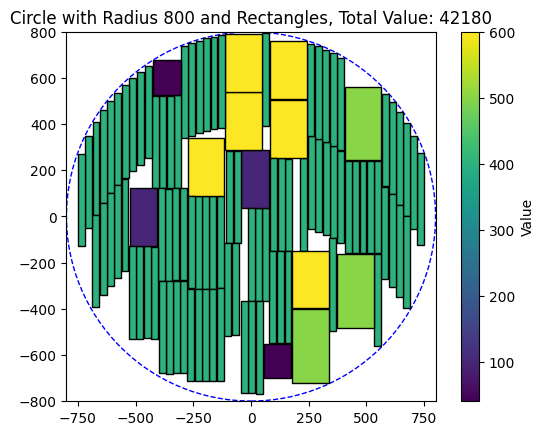

Radius 1000, Best Fitness: 22880, Min Fitness Required: 17500, Time: 58.2158567905426


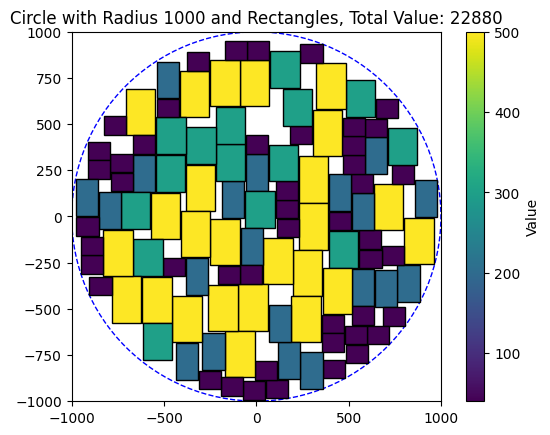

Radius 1100, Best Fitness: 30440, Min Fitness Required: 25000, Time: 50.00208520889282


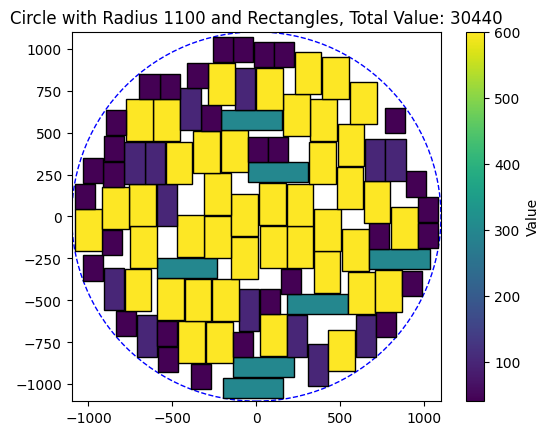

Radius 1200, Best Fitness: 34240, Min Fitness Required: 30000, Time: 106.83615493774414


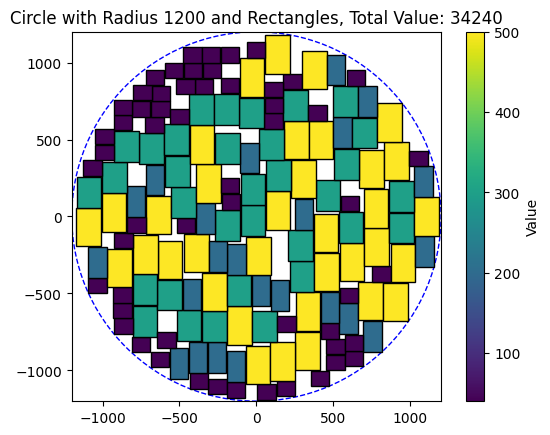

In [249]:
for r, data, min_fitness in zip([800, 1000, 1100, 1200], [r800, r1000, r1100, r1200], [30000, 17500, 25000, 30000]):
    ga = GAlgorithm(
        population_size=100,
        initial_chromosome_length=20,
        radius=r,
        rectangles=data,
        crossover_prob=0.7,
        mutation_prob=0.3,
        num_generations=20,
        verbose=0,
        rect_prob = 1,
        rotate = 0,
        init_max_iter = 2000
    )
    start = time.time()
    best_chromosome, best_fitness = ga.optimize()
    print('='*50)
    print(f'Radius {r}, Best Fitness: {best_fitness}, Min Fitness Required: {min_fitness}, Time: {time.time() - start}')
    plot_solution2(best_chromosome, r)

## Dalsze kombinacje

In [256]:
r800.iloc[4:5,:]

,0,1,2
4,400,30,400


Generation 1, best fitness: 8200
Generation 2, best fitness: 21600
Generation 3, best fitness: 34000
Generation 4, best fitness: 39600
Generation 5, best fitness: 44000
Generation 6, best fitness: 44800
Generation 7, best fitness: 45600
Generation 8, best fitness: 46800
Generation 9, best fitness: 47200
Generation 10, best fitness: 47600
Generation 11, best fitness: 47600
Generation 12, best fitness: 48400
Generation 13, best fitness: 48800
Generation 14, best fitness: 48800
Generation 15, best fitness: 49800
Radius 800, Best Fitness: 49800, Min Fitness Required: 30000, Time: 231.67169284820557


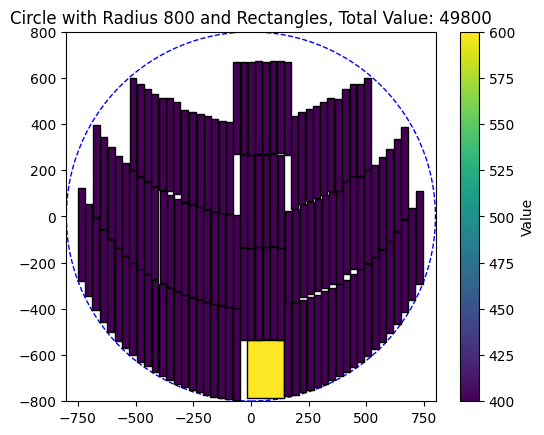

In [20]:

r=800
min_fitness = 30000
ga = GAlgorithm(
        population_size=100,
        initial_chromosome_length=20,
        radius=r,
        rectangles=r800,
        crossover_prob=0.7,
        mutation_prob=0.5,
        num_generations=15,
        verbose=1,
        rect_prob = 1,
        rotate = 0,
        init_max_iter = 2000
    )
start = time.time()
best_chromosome, best_fitness = ga.optimize()
print('='*50)
print(f'Radius {r}, Best Fitness: {best_fitness}, Min Fitness Required: {min_fitness}, Time: {time.time() - start}')
plot_solution2(best_chromosome, r)

Generation 1, best fitness: 8100
Generation 2, best fitness: 22000
Generation 3, best fitness: 38800
Generation 4, best fitness: 44000
Generation 5, best fitness: 47600
Generation 6, best fitness: 47600
Generation 7, best fitness: 47600
Generation 8, best fitness: 47600
Generation 9, best fitness: 47600
Generation 10, best fitness: 47600
Generation 11, best fitness: 47600
Generation 12, best fitness: 48000
Generation 13, best fitness: 48400
Generation 14, best fitness: 48400
Generation 15, best fitness: 48400
Generation 16, best fitness: 48400
Generation 17, best fitness: 48400
Generation 18, best fitness: 49040
Generation 19, best fitness: 49040
Generation 20, best fitness: 49080
Generation 21, best fitness: 49120
Generation 22, best fitness: 49120
Generation 23, best fitness: 49160
Generation 24, best fitness: 49160
Generation 25, best fitness: 49160
Generation 26, best fitness: 49160
Generation 27, best fitness: 49160
Generation 28, best fitness: 49160
Generation 29, best fitness: 4

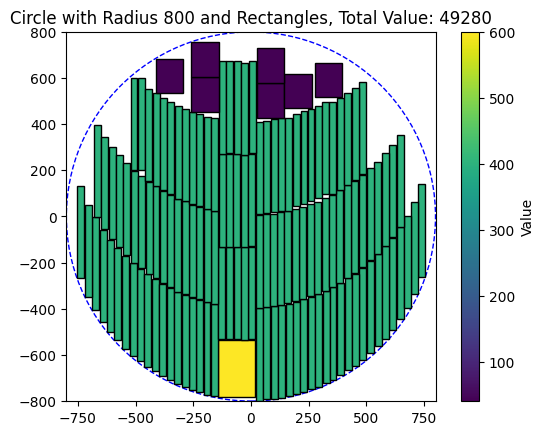

In [22]:
# plot_solution2(best_chromosome, r)
r=800
min_fitness = 30000
ga = GAlgorithm(
        population_size=110,
        initial_chromosome_length=20,
        radius=r,
        rectangles=r800,
        crossover_prob=0.7,
        mutation_prob=0.5,
        num_generations=30,
        verbose=1,
        rect_prob = 1,
        rotate = 0,
        init_max_iter = 1000
    )
start = time.time()
best_chromosome, best_fitness = ga.optimize()
print('='*50)
print(f'Radius {r}, Best Fitness: {best_fitness}, Min Fitness Required: {min_fitness}, Time: {time.time() - start}')
plot_solution2(best_chromosome, r)

Generation 1, best fitness: 8000
Generation 2, best fitness: 21600
Generation 3, best fitness: 37200
Generation 4, best fitness: 42000
Generation 5, best fitness: 45200
Generation 6, best fitness: 46400
Generation 7, best fitness: 46400
Generation 8, best fitness: 47200
Generation 9, best fitness: 47600
Generation 10, best fitness: 48000
Generation 11, best fitness: 48400
Generation 12, best fitness: 48400
Generation 13, best fitness: 48400
Generation 14, best fitness: 48800
Generation 15, best fitness: 49200
Generation 16, best fitness: 49200
Generation 17, best fitness: 49200
Generation 18, best fitness: 49200
Generation 19, best fitness: 49200
Generation 20, best fitness: 49200
Radius 800, Best Fitness: 49200, Min Fitness Required: 30000, Time: 205.55254125595093


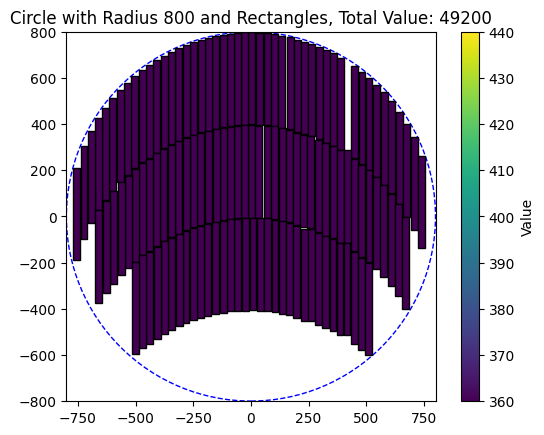

In [257]:

r=800
ga = GAlgorithm(
        population_size=100,
        initial_chromosome_length=20,
        radius=r,
        rectangles=r800.iloc[4:5,:],
        crossover_prob=0.7,
        mutation_prob=0.5,
        num_generations=20,
        verbose=1,
        rect_prob = 1,
        rotate = 0,
        init_max_iter = 2000
    )
start = time.time()
best_chromosome, best_fitness = ga.optimize()
print('='*50)
print(f'Radius {r}, Best Fitness: {best_fitness}, Min Fitness Required: {min_fitness}, Time: {time.time() - start}')
plot_solution2(best_chromosome, r)

Generation 1, best fitness: 13800
Generation 2, best fitness: 18960
Generation 3, best fitness: 20720
Generation 4, best fitness: 22460
Generation 5, best fitness: 25460
Generation 6, best fitness: 26740
Generation 7, best fitness: 26740
Generation 8, best fitness: 27580
Generation 9, best fitness: 27720
Generation 10, best fitness: 27860


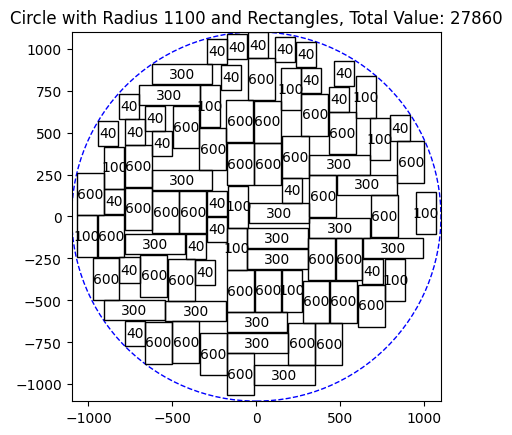

In [235]:
g = GAlgorithm(
    population_size=100, 
    initial_chromosome_length=25, 
    radius=1100,
    # rectangles=r800.iloc[4:5, :],
    rectangles=r1100,

    rect_prob=1,
    crossover_prob=0.7, 
    mutation_prob=0.2, 
    num_generations=10,
    verbose=True,
    initial_sigma=10,
    sigma_decay=0.05,
    rotate=0,
    init_max_iter=1000
)
g._initialize_population()
# g.directions[:8]
# g.optimize()
best_chromosome, best_fitness = g.optimize()
plot_solution(best_chromosome, 1100)

# plot_solution(g.population[0], 800)

# print(len(g.population[0]))
# g.directions[:4]

Generation 1, best fitness: 9240
Generation 2, best fitness: 11760
Generation 3, best fitness: 16520
Generation 4, best fitness: 20420
Generation 5, best fitness: 20500
Generation 6, best fitness: 20860
Generation 7, best fitness: 21380
Generation 8, best fitness: 21900
Generation 9, best fitness: 22360
Generation 10, best fitness: 22360


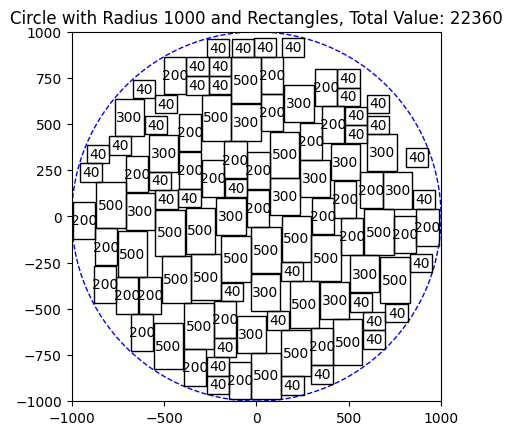

In [236]:
g = GAlgorithm(
    population_size=100, 
    initial_chromosome_length=25, 
    radius=1000,
    # rectangles=r800.iloc[4:5, :],
    rectangles=r1000,

    rect_prob=1,
    crossover_prob=0.7, 
    mutation_prob=0.2, 
    num_generations=10,
    verbose=True,
    initial_sigma=10,
    sigma_decay=0.05,
    rotate=0,
    init_max_iter=1000
)
g._initialize_population()
# g.directions[:8]
# g.optimize()
best_chromosome, best_fitness = g.optimize()
plot_solution(best_chromosome, 1000)

# plot_solution(g.population[0], 800)

# print(len(g.population[0]))
# g.directions[:4]

[(207.56985801116377, 101.62698353127155, 320, 160, 500), (215.37443155973733, -238.2718292772422, 250, 160, 600), (121.12360868785788, 153.53921290869732, 400, 30, 400), (145.19934562274534, -488.06835584803866, 400, 30, 400), (-153.27378178755419, 300.099748664393, 250, 160, 600), (-248.7324302280092, -181.32830333660525, 250, 160, 600), (-303.0015926964308, 55.82135411898514, 400, 30, 400), (-275.4752968413794, -585.2241043696099, 400, 30, 400), (-374.8551896417622, 193.10278248878535, 400, 30, 400), (-586.8940152246723, -428.6010216153121, 250, 120, 100)]


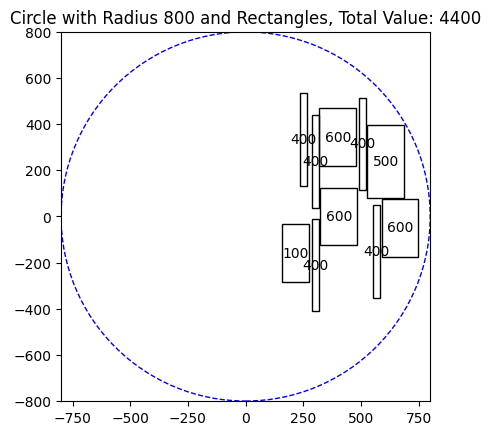

In [57]:
chromosome = g._shift(g.population[0], g.directions[0])
plot_solution(chromosome, 800)